# Notebook for CPEN 534 Course projects

This notebook contains the scripts to run all experiments and generate all figures in the poster (and its Extended Abstract).
Please follow the these step:
1. Run `pipenv install` to install the python dependencies specified in `Pipfile` and `Pipfile.lock`.
2. Ensure `go version` is `1.22.1`.
3. Update the values of `path_to_graph`, `path_to_project`, and `threads` in the next cell.
4. Run all cells in this notebook with the python environment created in Step 1.
5. The results will be saved in the directory `results/2024-cpen534/`.

In [2]:
# 
project_path = "~/projects/lollipop" # root of the repository
path_hive_comments = "~/hive-comments.txt"
path_wikipedia_growth = "~/wikipedia-growth.txt"
path_eth_transfers = "~/eth-transfers-t200m.txt.p"
path_flickr = "~/flickr-growth.txt"
path_roadnet = "~/roadNet-CA.txt.shuffled" # shuffled with random edge weights added # ignore this for now

default_thread = 16

In [3]:
import subprocess as sp
from pathlib import Path
import shutil
import re
import time
import statistics
import os, signal
from dataclasses import dataclass
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

mpl.rcParams['figure.dpi'] = 600

In [4]:
go = Path(shutil.which("go"))
project_path = Path(project_path).expanduser()
path_hive_comments = Path(path_hive_comments).expanduser()
path_wikipedia_growth = Path(path_wikipedia_growth).expanduser()
path_eth_transfers = Path(path_eth_transfers).expanduser()
path_flickr = Path(path_flickr).expanduser()
path_roadnet = Path(path_roadnet).expanduser()
assert go.exists()
assert project_path.exists()
assert path_hive_comments.exists()
assert path_wikipedia_growth.exists()
assert path_eth_transfers.exists()
assert path_flickr.exists()
assert path_roadnet.exists()

# TODO: check hashes of graph files

# push_relabel_code = project_path / "cmd" / f"lp-push-relabel"
# assert push_relabel_code.exists()
pagerank_code = project_path / "cmd" / f"lp-pagerank"
assert pagerank_code.exists()

In [5]:
def create_results_directory(top_dir: Path):
    results_dir = top_dir / f"2023-bigdata"
    log_dir = results_dir / "log"
    ts_dir = results_dir / "ts"
    output_dir = results_dir / "output"
    results_dir.mkdir(exist_ok=True)
    log_dir.mkdir(exist_ok=True)
    ts_dir.mkdir(exist_ok=True)
    output_dir.mkdir(exist_ok=True)
    return results_dir, output_dir, log_dir, ts_dir

(project_path / "results").mkdir(exist_ok=True)
results_dir, output_dir, log_dir, ts_dir = create_results_directory(project_path / "results")
path_timeseries_output = project_path / "results" / "push-relabel-timeseries.csv"
path_timeseries_flow_output = project_path / "results" / "push-relabel-timeseries-flow.csv"

In [6]:
@dataclass(kw_only=True)
class Graph:
    name: str
    path: Path
    pw: int
    pt: int
    undirected: bool = False

@dataclass(kw_only=True)
class ExperimentConfig:
    graph: Graph
    st_index: int
    s: int
    t: int

    def get_name(self) -> str:
        return f"{self.graph.name}-{self.st_index}"

@dataclass(kw_only=True)
class BasicTestCase(ExperimentConfig):
    threads: int = default_thread

@dataclass(kw_only=True)
class StaticTestCase(BasicTestCase):
    pass

@dataclass(kw_only=True)
class DynamicTestCase(BasicTestCase):
    target_ingest_rate: int = 0
    delete_window: int = 0

@dataclass(kw_only=True)
class TimeseriesTestCase(DynamicTestCase):
    interval_time: int = None
    interval_edge: int = None

    def __post_init__(self):
        assert (self.interval_time and not self.interval_edge) or \
            (not self.interval_time and self.interval_edge), \
            "Exactly one of dt or de must set"

graph_hive_comments = Graph(name="Hive-comments", path=path_hive_comments, pw=None, pt=1)
graph_wikipedia_growth = Graph(name="Wikipedia-growth", path=path_wikipedia_growth, pw=None, pt=2)
graph_eth_transfers = Graph(name="Eth-transfers", path=path_eth_transfers, pw=1, pt=2)
graph_flickr_growth = Graph(name="Flickr-growth", path=path_flickr, pw=None, pt=2)
graph_roadnet = Graph(name="RoadNet-CA", path=path_roadnet, pw=1, pt=None)

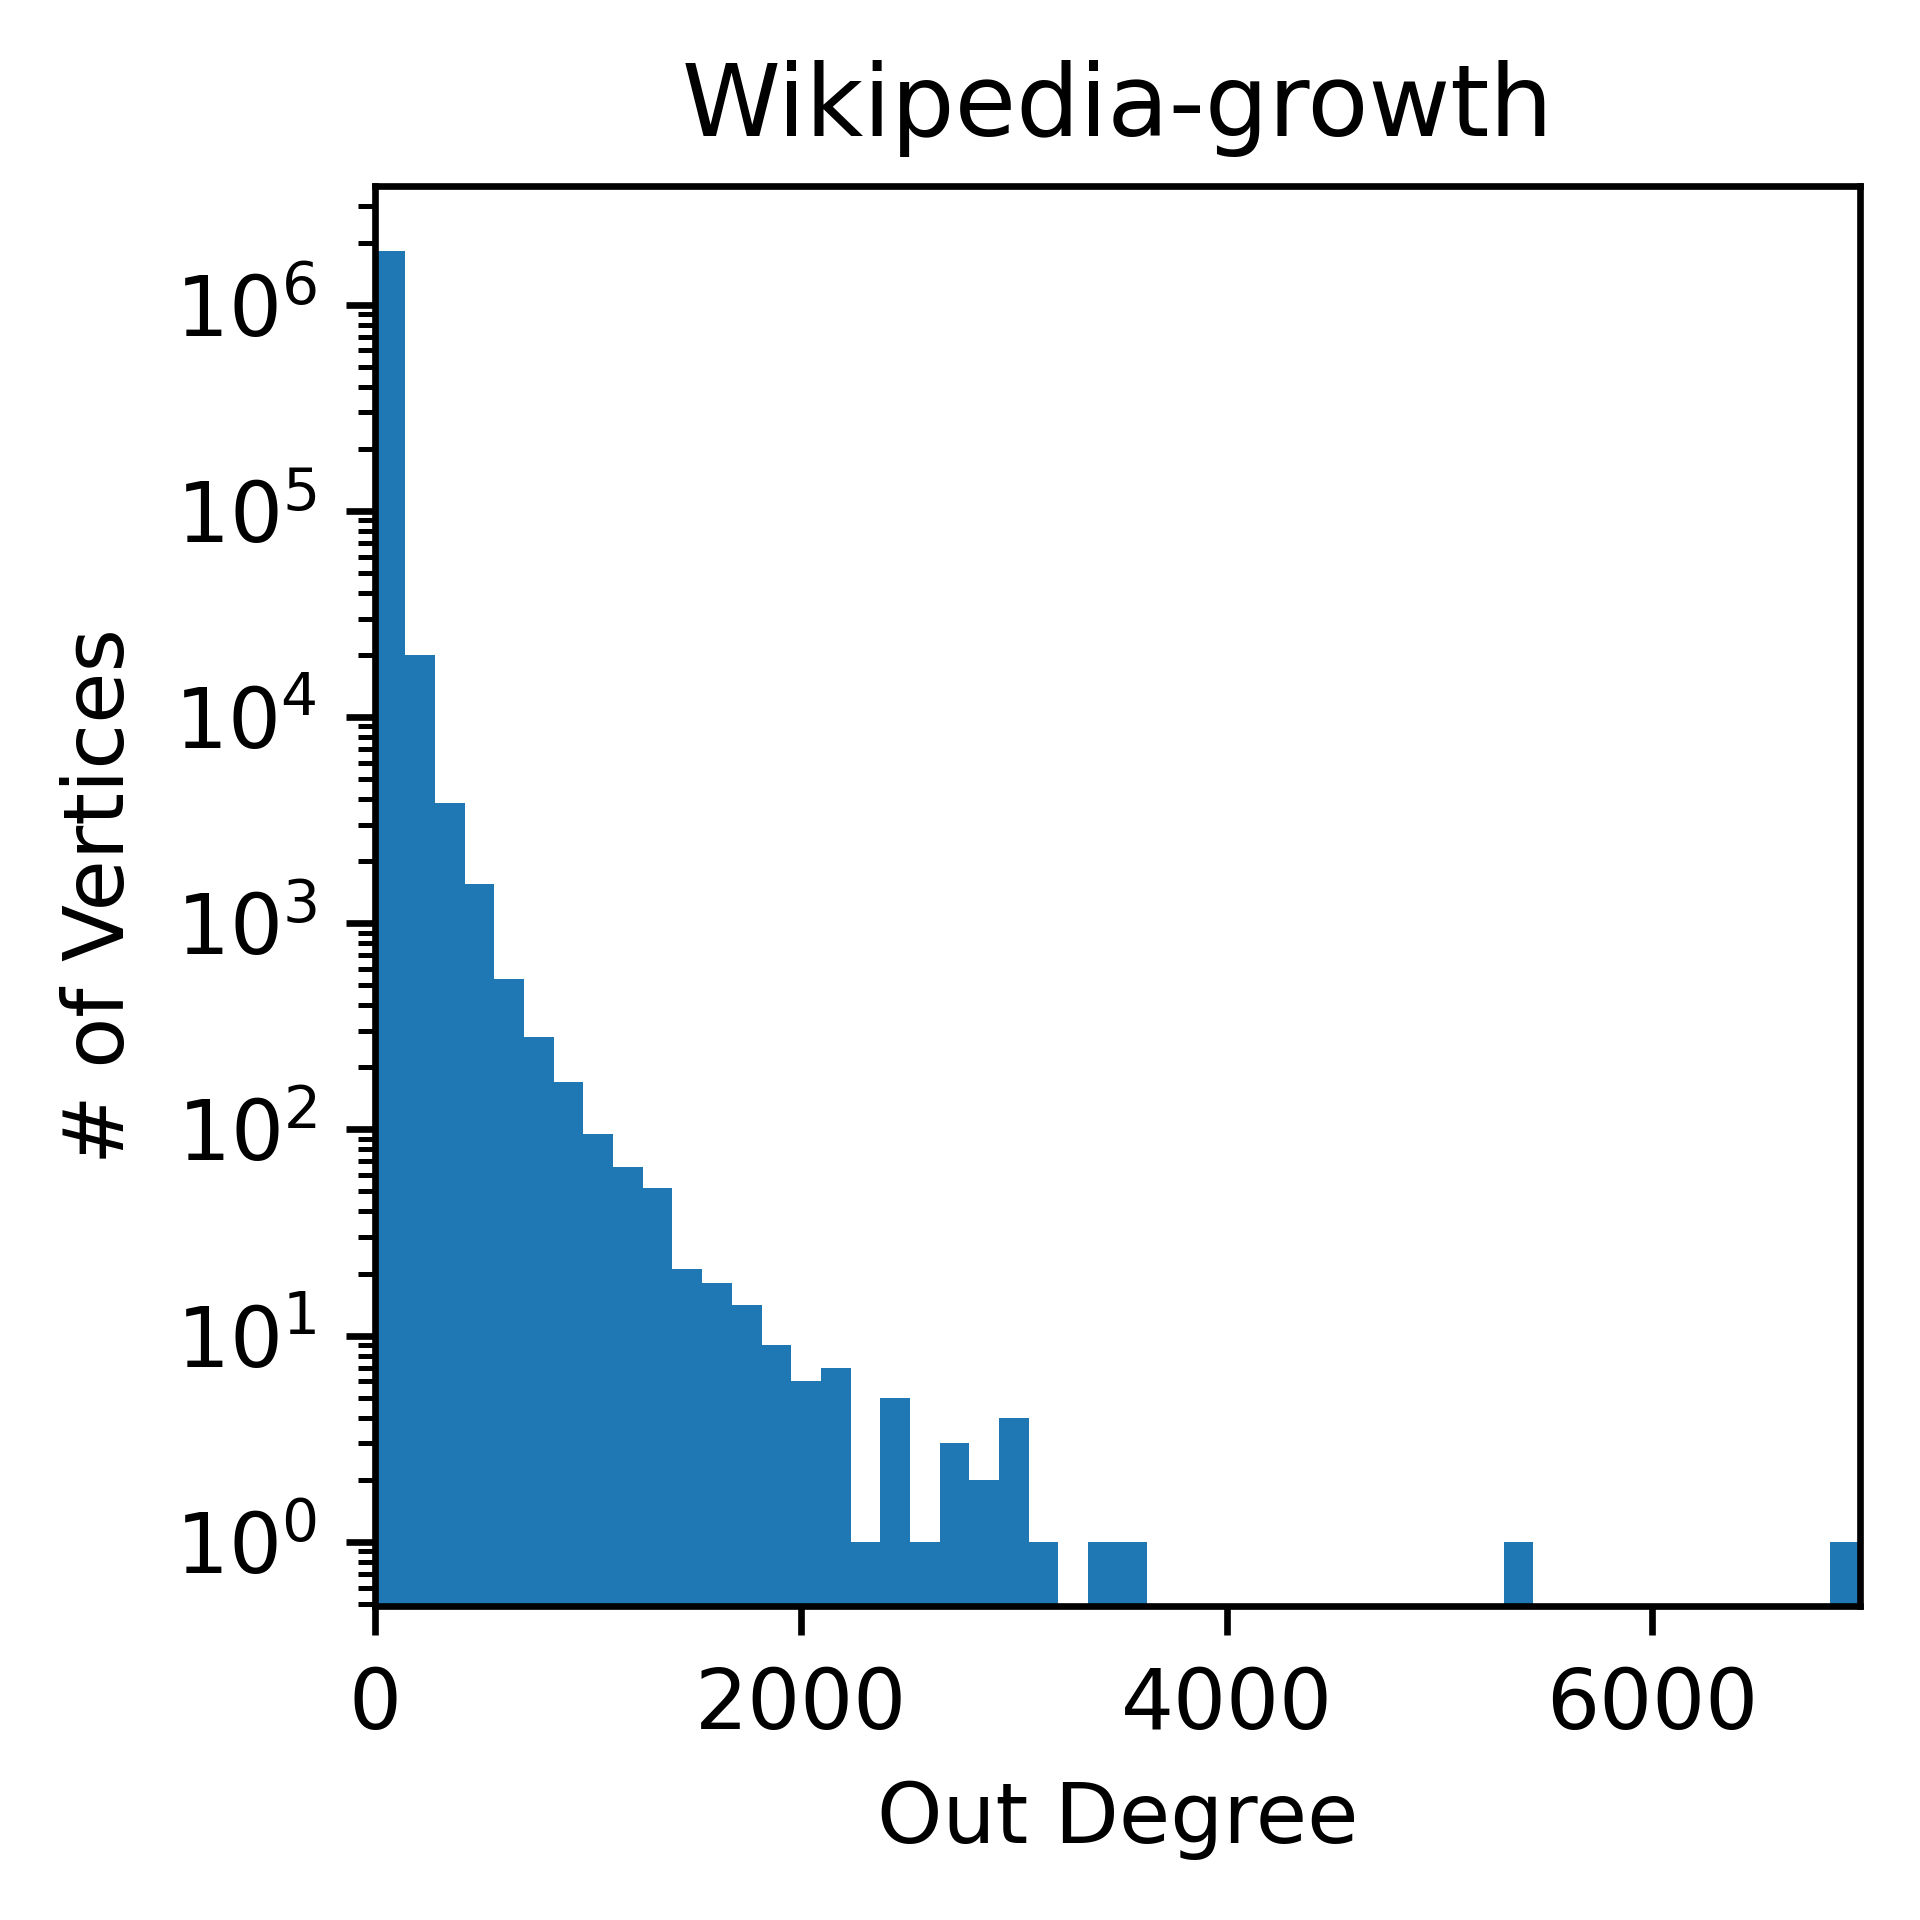

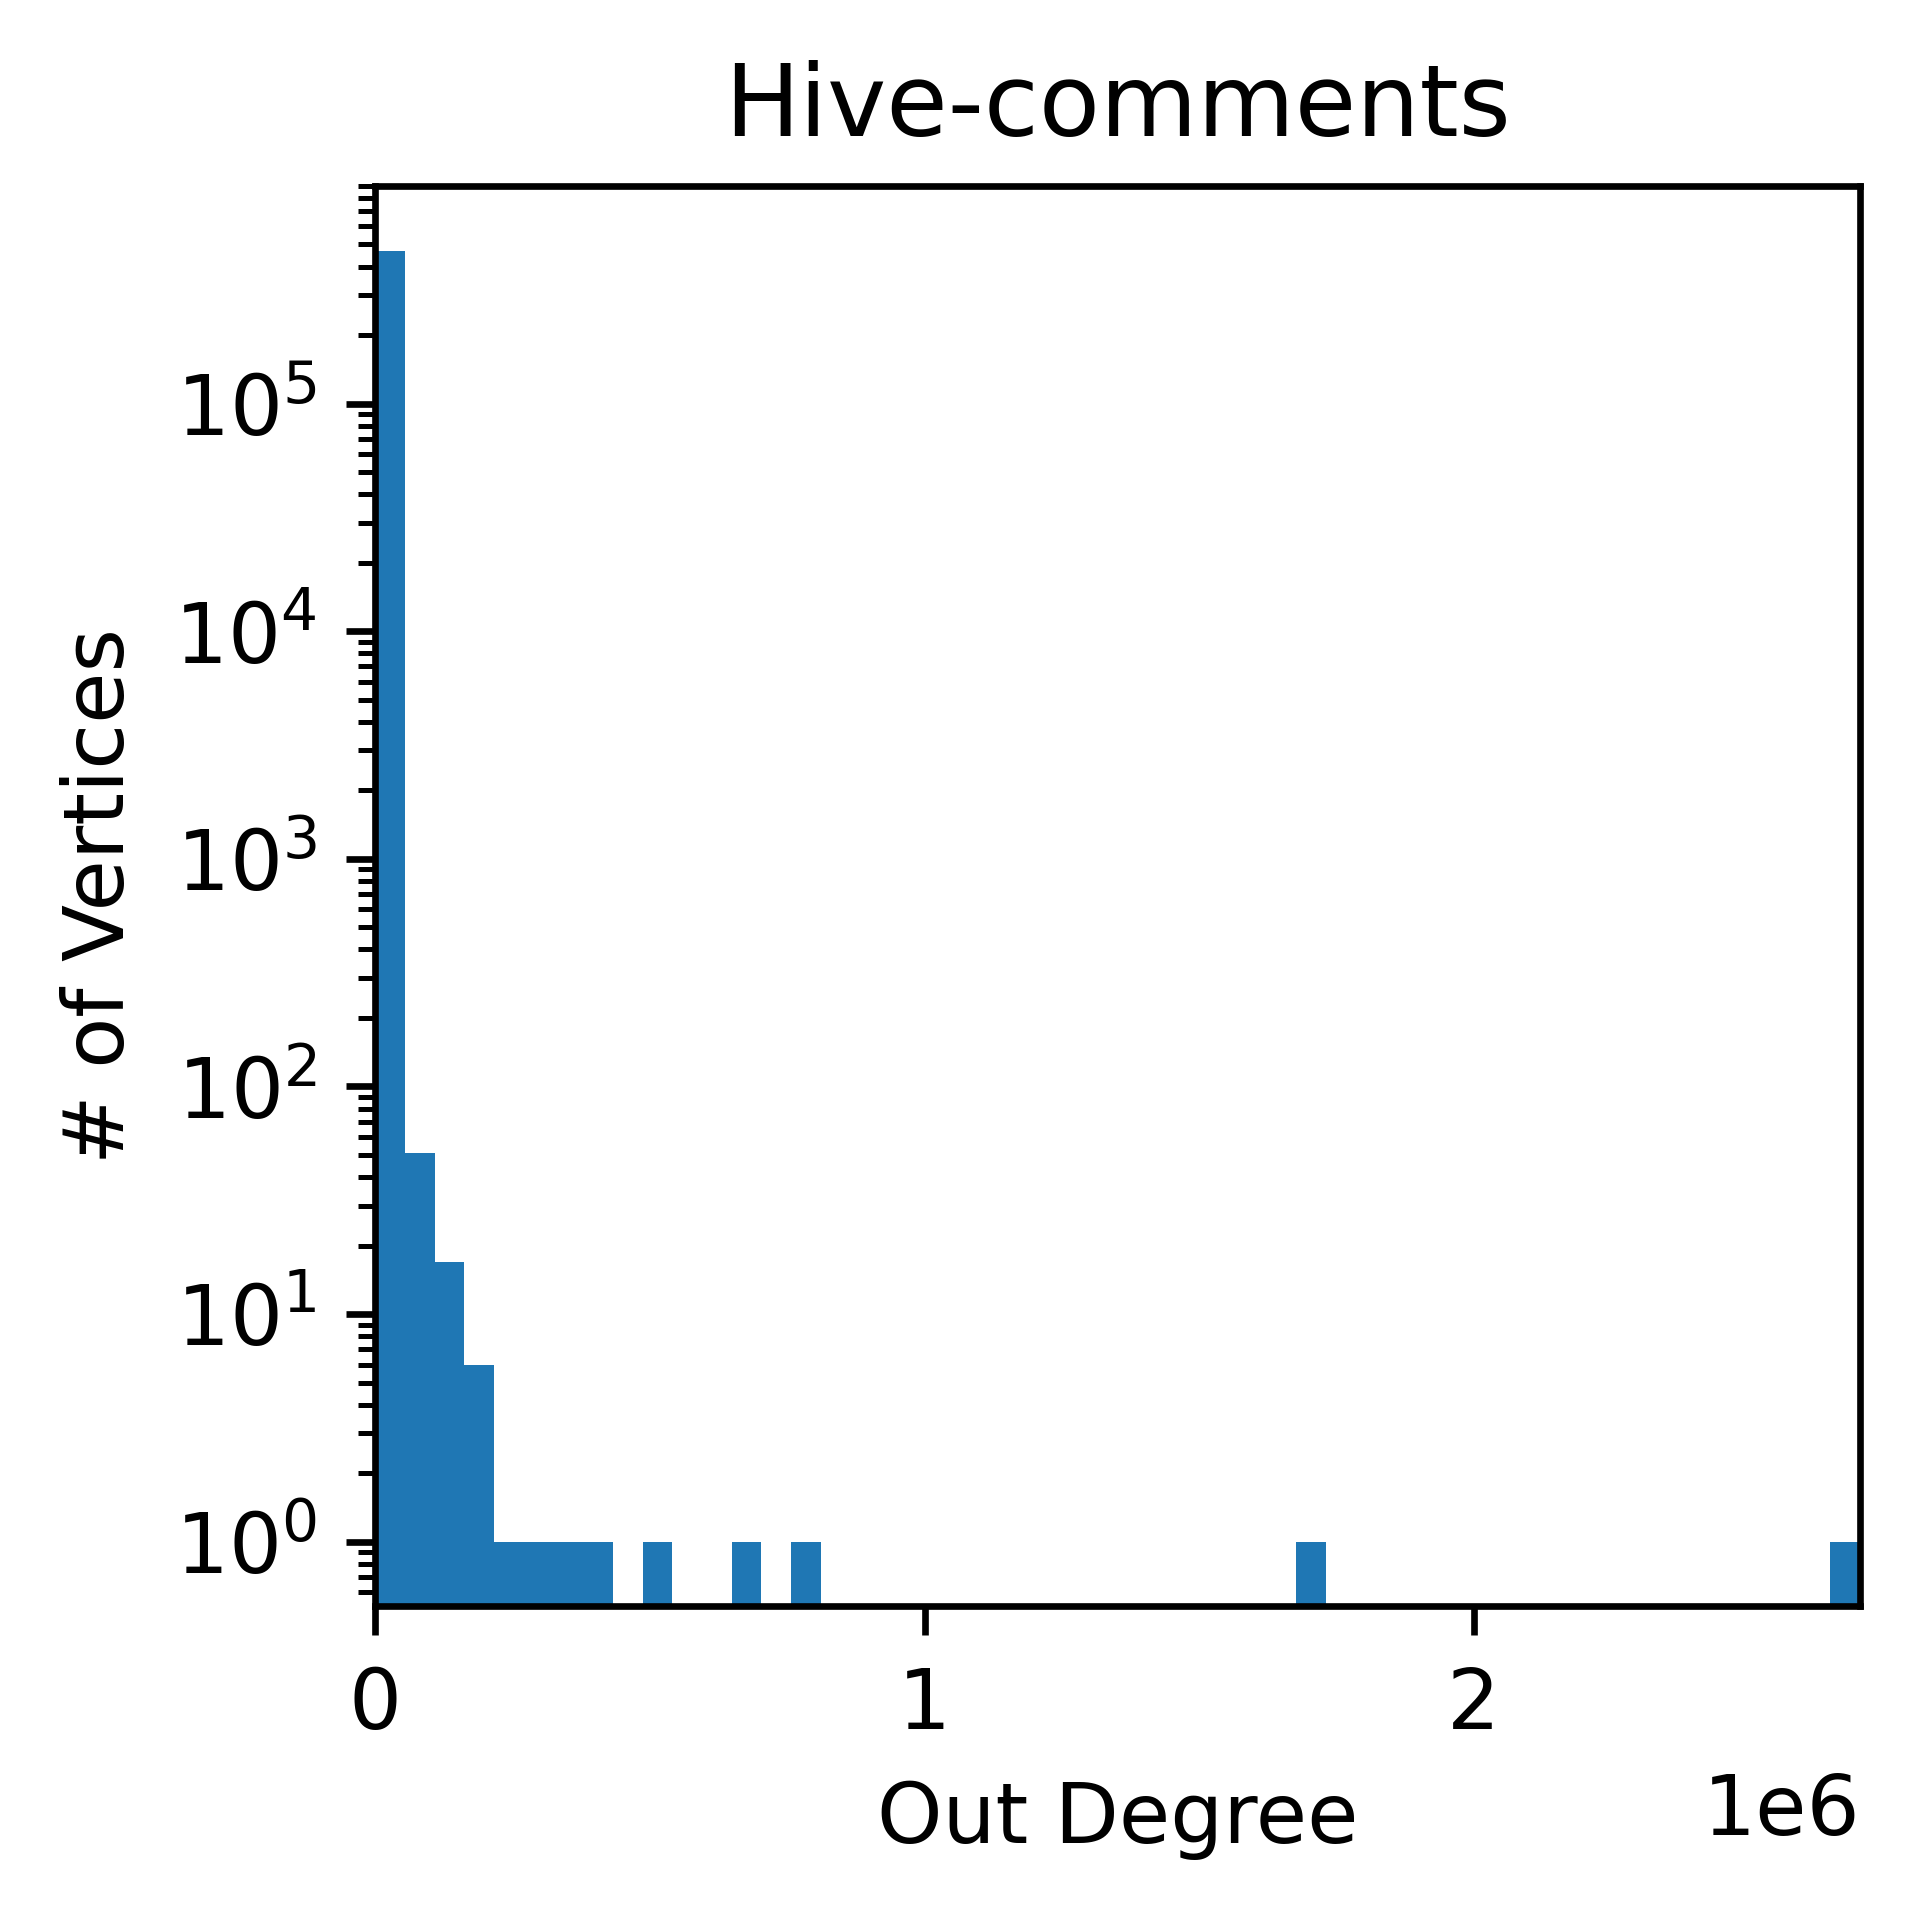

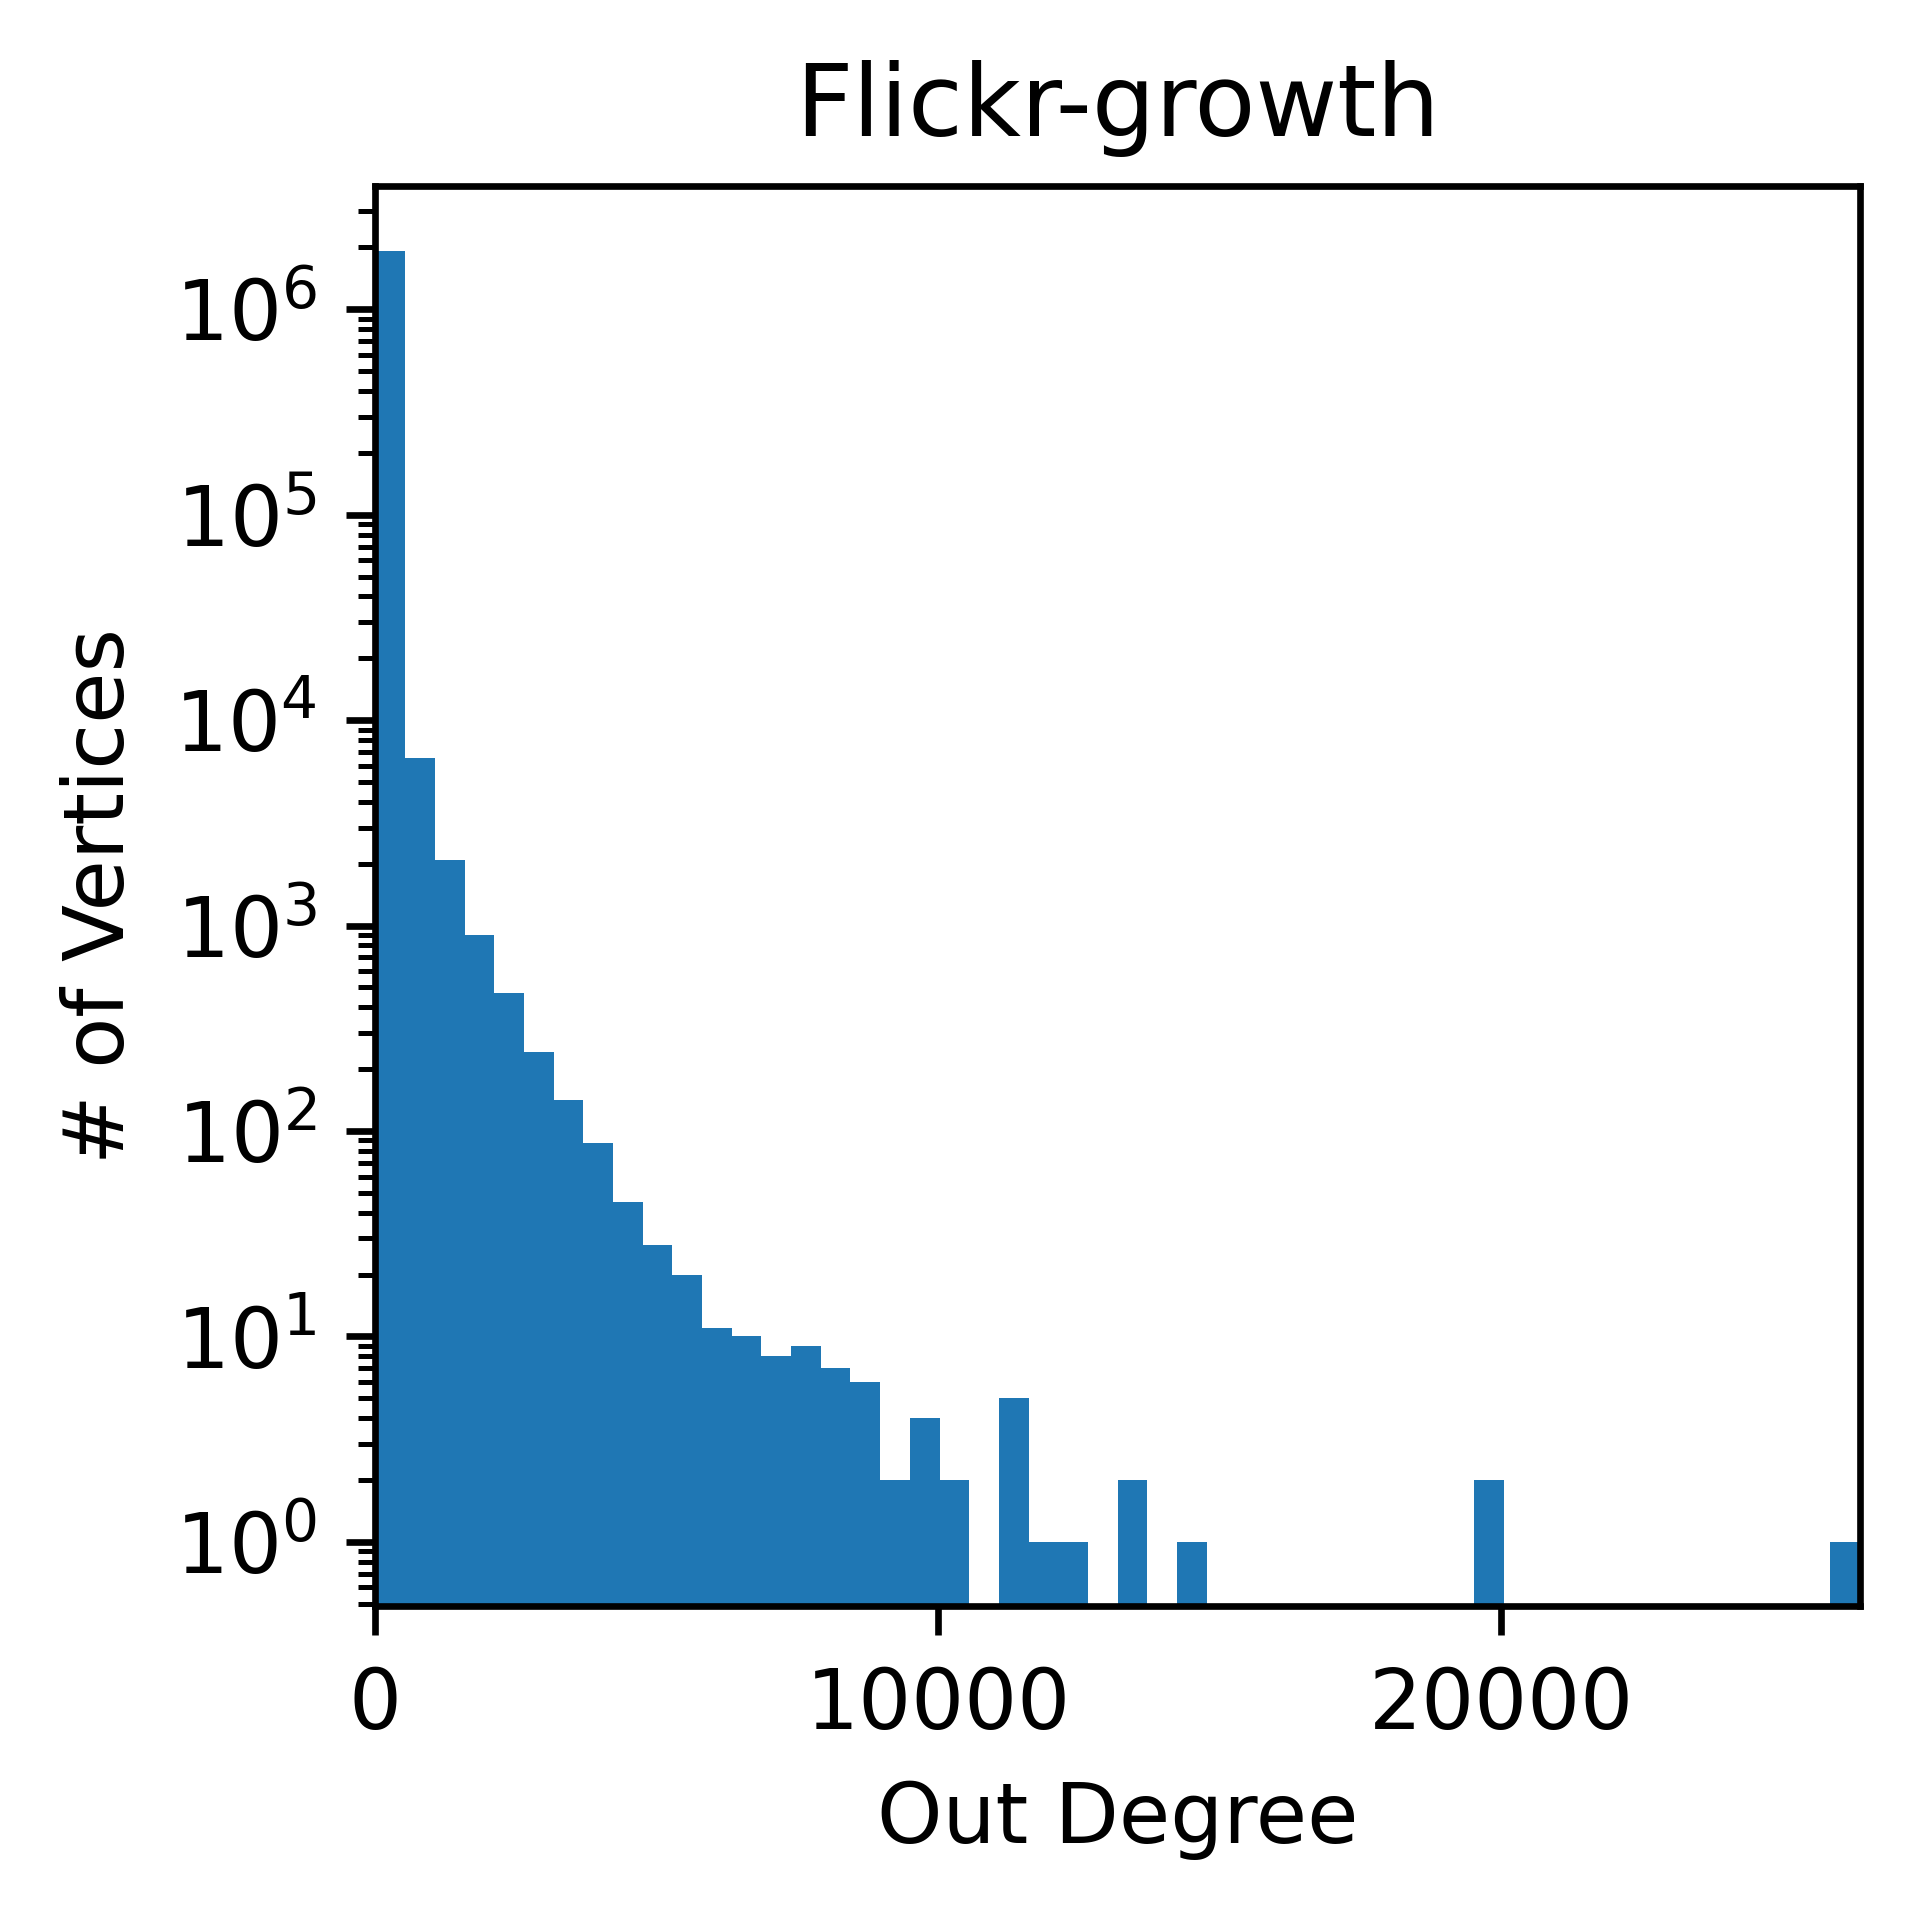

In [20]:
def plot_histogram(g: Graph, xlog: bool = False):
    degrees = dict()
    with open(g.path) as file:
        for line in file:
            src, _ = line.split(maxsplit=1)
            if src not in degrees:
                degrees[src] = 1
            else:
                degrees[src] += 1

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.set(title=f'{g.name}', xlabel='Out Degree', ylabel='# of Vertices', yscale='log', xlim=[0, max(degrees.values())])
    # if xlog:
    #     ax.set(xscale='log')
    ax.hist(degrees.values(), bins=100)

    fig.tight_layout(pad=0)
    fig.savefig(output_dir / f"degree-histogram-{g.name}.pdf", bbox_inches='tight')

plot_histogram(graph_wikipedia_growth)
plot_histogram(graph_hive_comments, xlog=True)
plot_histogram(graph_flickr_growth)

In [9]:
@dataclass
class Result:
    test_case: TimeseriesTestCase
    time_alg: int
    # time_general: int
    total_msg: int
    total_remote_msg: int
    maxThreadMsgRecv: int
    maxThreadMsgRecv_ratio: float # ratio to avg
    maxThreadRemoteMsgRecv: int
    maxThreadRemoteMsgRecv_ratio: float
    maxThreadVertices: int
    maxThreadVertices_ratio: float
    maxThreadEdges: int
    maxThreadEdges_ratio: float

def get_result(tc: TimeseriesTestCase, path_log: Path) -> Result:
    assert isinstance(tc, StaticTestCase)

    log = path_log.read_text()

    time_alg = re.findall(r"Termination: ([0-9]+)", log)
    assert len(time_alg) == 1 
    time_alg = int(time_alg[0])

    msg_stat = re.findall(r"maxThreadMsgRecv \(ratio to avg\): ([0-9]+) \(([+-]?\d+(?:\.\d+)?)\) maxThreadRemoteMsgRecv \(ratio to avg\): ([0-9]+) \(([+-]?\d+(?:\.\d+)?)\)", log)
    assert len(msg_stat) == 4
    maxThreadMsgRecv = int(msg_stat[0])
    maxThreadMsgRecv_ratio = float(msg_stat[1])
    maxThreadRemoteMsgRecv = int(msg_stat[2])
    maxThreadVertices_ratio = float(msg_stat[3])

    # time_general = re.findall(r"Total including streaming: ([0-9]+)", log)
    # assert len(time_general) == 1 
    # time_general = int(time_general[0])
    
    return Result(test_case=tc, time_alg=time_alg, time_general=time_general)

In [ ]:
def run_algorithm(tc: BasicTestCase, repeat_index: int = 0, correctness: bool = True, add_flags: list[str] = [], suffix: str = "", no_skip: bool = False) -> Path:
    assert isinstance(tc, BasicTestCase)

    # compile command and log filename
    cmd = [go, "run", push_relabel_code, "-nc", f"-t={tc.threads}", f"-g={tc.graph.path}"]
    log_filename = f"push-relabel-t={tc.threads}-g={tc.graph.path.name}"
    if tc.graph.undirected:
        cmd.append("-u")
        log_filename += "-u"
    if tc.graph.pw:
        cmd += [f"-pw={tc.graph.pw}"]
        log_filename += f"-pw={tc.graph.pw}"
    if tc.graph.pt:
        cmd += [f"-pt={tc.graph.pt}"]
        log_filename += f"-pt={tc.graph.pt}"

    cmd += [f"-S={tc.s}", f"-T={tc.t}"]
    log_filename += f"-S={tc.s}-T={tc.t}"

    if correctness:
        cmd += ["-c"]
        log_filename += "-c"

    cmd += add_flags
    log_filename += f"{suffix}.{repeat_index}.log"

    # Run command
    log_path = log_dir / log_filename
    print(f"Command: {cmd}")
    print(f"Log path: {log_path}")

    if (not no_skip) and log_path.exists():
        print(f"Skipped as the log file exists")
        return log_path

    path_log_temp = log_dir / f"_running-{log_filename}"
    with open(path_log_temp, "w+t") as log_file:
        def preexec_fn():
            os.setpgrp()
        process = sp.Popen(cmd, cwd=project_path, stdout=log_file, stderr=sp.STDOUT, preexec_fn=preexec_fn)
        time.sleep(0.5)
        try:
            returncode = process.wait()
        except KeyboardInterrupt as ki:
            os.killpg(os.getpgid(process.pid), signal.SIGTERM)
            process.kill()
            raise ki
        if returncode != 0:
            assert False, f"Return code is none-zero: {returncode}"
    
    path_log_temp.rename(log_path)
    print(f"Log saved")
    
    return log_path

def run_algorithm_static(tc: StaticTestCase, **kwargs) -> StaticResult:
    assert isinstance(tc, StaticTestCase)

    path_log = run_algorithm(tc=tc, **kwargs)
    return get_static_result(tc=tc, path_log=path_log)

def run_algorithm_ts(tc: TimeseriesTestCase, repeat_index: int = 0, stability: bool = False, no_skip: bool = False, **kwargs) -> TimeseriesResult:
    assert isinstance(tc, TimeseriesTestCase)
    assert (tc.interval_time and not tc.interval_edge) or (not tc.interval_time and tc.interval_edge), "Exactly one of dt or de must set"
    assert not tc.track_progress or not stability

    path_timeseries_output.unlink(missing_ok=True)
    
    add_flags = ["-tquery"]
    if tc.interval_time:
        add_flags += [f"-dt={tc.interval_time}"]
    if tc.interval_edge:
        add_flags += [f"-de={tc.interval_edge}"]
    if tc.target_ingest_rate:
        add_flags += [f"-dr={tc.target_ingest_rate}"]
    if tc.delete_window:
        add_flags += [f"-w={tc.delete_window}"]
    if tc.track_progress:
        add_flags += [f"-debug=2"]
    
    if stability:
        add_flags.append("-Stability")

    suffix = "".join(add_flags)

    kwargs["add_flags"] = add_flags + kwargs.get("add_flags", [])
    kwargs["suffix"] = suffix + kwargs.get("suffix", "")
    path_log = run_algorithm(tc=tc, repeat_index=repeat_index, no_skip=no_skip, **kwargs)

    path_timeseries = ts_dir / (path_log.name[:-4] + f".csv")
    path_timeseries_flow = None
    if not no_skip and path_timeseries.exists():
        print(f"Timeseries already exists: {path_timeseries}")
        if stability:
            path_timeseries_flow = ts_dir / (path_log.name[:-4] + f"-flow.csv")
            assert path_timeseries_flow.exists()
    else:
        assert path_timeseries_output.exists(), "No timeseries output found"
        path_timeseries_output.rename(path_timeseries)
        print(f"Timeseries saved to: {path_timeseries}")
    
        if stability:
            path_timeseries_flow = ts_dir / (path_log.name[:-4] + f"-flow.csv")
            assert path_timeseries_flow_output.exists()
            path_timeseries_flow_output.rename(path_timeseries_flow)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    return get_ts_result(tc=tc, path_log=path_log, path_timeseries=path_timeseries, path_timeseries_flow=path_timeseries_flow)

In [ ]:
class SaturationTest:
    def __init__(self, testcases: list[list[BasicTestCase]], query_intervals: list[int], plot_latency: bool = False) -> None:
        self.testcases = testcases
        self.query_intervals = sorted(query_intervals)
        self.common_rates = [("VisaNet Transactions", 6000, -13), ("Worldwide Emails Sent/Received", 10000, 4.5)]
        # ("Ethereum Transactions", 12, 4), 
        self.plot_latency = plot_latency

        indices = self.query_intervals
        columns = []
        for tcs in testcases:
            columns += [f"{tcs[0].graph.name}-top", f"{tcs[0].graph.name}-mid", f"{tcs[0].graph.name}-bot"]
        self.results = pd.DataFrame(index=indices, columns=columns)

    def run(self) -> None:
        for interval in self.query_intervals:
            for tcs_graph in self.testcases:
                ys = []
                for tc in tcs_graph:
                    tc_ts = TimeseriesTestCase(interval_time=interval, **tc.__dict__)
                    result = run_algorithm_ts(tc=tc_ts)
                    ys.append(result.latency_mean/1000 if self.plot_latency else float(result.ingest_rate_actual))
                self.results.at[interval, f"{tcs_graph[0].graph.name}-top"] = max(ys)
                self.results.at[interval, f"{tcs_graph[0].graph.name}-mid"] = statistics.median(ys)
                self.results.at[interval, f"{tcs_graph[0].graph.name}-bot"] = min(ys)
        return self.results

    def plot(self, figsize) -> None:
        ymin, ymax = (0, 5) if self.plot_latency else (3e3, 1e7)
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        x = self.results.index.astype(int)
        ax.set_xscale('log')
        if not self.plot_latency:
            ax.set_yscale('log')
        ax.set_xticks(self.results.index)
        ax.set_xticklabels(self.results.index)
        ax.set(ylim=[ymin, ymax])
        ax.invert_xaxis()
        for tcs, mk, ms, color in zip(self.testcases, ["x", "d", "."], [5, 4, 7], ["#1f77b4", "#ff7f0e", "#2ca02c"]):
            name = tcs[0].graph.name
            ax.plot(x, self.results.loc[:, f"{name}-mid"], mk+"-", markersize=ms, color=color, label=f"{name}")
            ax.plot(x, self.results.loc[:, f"{name}-top"], mk+"--", markersize=ms, color=color, alpha=0.7)
            ax.plot(x, self.results.loc[:, f"{name}-bot"], mk+"--", marker=mk, markersize=ms, color=color, alpha=0.7)
            ax.fill_between(x, self.results.loc[:, f"{name}-top"].astype(float), self.results.loc[:, f"{name}-bot"].astype(float), color=color, alpha=0.3)
        
        # ax.plot(x, df.loc[:, "(C)onstruction Only"] / 1000, "x-", color="chocolate", label="(C)onstruction Only", markersize=5)
        # ax.plot(x, df.loc[:, "(S)tatic"] / 1000, "D-", color="purple", label="(S)tatic", markersize=3)
        # ax.plot(x, df.loc[:, "(C)+(S)"] / 1000, "s-", color="firebrick", label="(C)+(S)", markersize=3)
        # ax.plot(x, df.loc[:, "Dynamic"] / 1000, ".-", color="royalblue", label="Dynamic", markersize=5)


        ax.xaxis.grid(alpha=0.3)
        ax.yaxis.grid(alpha=0.3)
        fig.legend(bbox_to_anchor=(0.51, 0.92), loc='center', ncol=3, framealpha=1, prop={'size': 7.5})

        xlim = ax.get_xlim()
        ax.set_xlim([1024*1.1, 1*0.9])
        if not self.plot_latency:
            for label, rate, y_offset in self.common_rates:
                lines = ax.plot([xlim[0], xlim[1]], [rate]*2, '--')
                ax.annotate(f"{label}", (max(x), rate), xytext=(1, y_offset), textcoords='offset points', color=lines[0].get_color())

        ax.set_xlabel(f"Query Interval (dataset days)", labelpad=6)
        ax.set_ylabel(f"Mean Latency During Evolution (second)" if self.plot_latency else "Throughput (events/second)", labelpad=6)

        ax.set(frame_on=False)
        ax.tick_params(bottom=False, left=False)
        ax.minorticks_off()

        return fig

n = 10
saturation_test = SaturationTest(testcases=[tc_hive_comments[:n]], query_intervals=[1024, 256, 64, 16, 4, 1], plot_latency=True)
result = saturation_test.run()
fig = saturation_test.plot((6,3))
fig.savefig(output_dir / "saturation.pdf", bbox_inches='tight')
result

In [ ]:
class ProgressExperiment():
    def __init__(self, testcases: (list[BasicTestCase], str), query_interval: int) -> None:
        self.testcases = testcases
        self.query_interval = query_interval
        self.results = None
    
    def run(self) -> (pd.DataFrame, pd.DataFrame):
        self.results = []
        for tc, name in self.testcases:
            tc_ts = TimeseriesTestCase(interval_time=self.query_interval, track_progress=True, **tc.__dict__)
            result = run_algorithm_ts(tc=tc_ts)
            self.results.append((name, result.progress))
        return self.results

    def plot(self, figsize) -> plt.Figure:
        results = self.results if self.results != None else self.run()
        fig, axs = plt.subplots(len(results), 1, figsize=figsize)
        if len(results) == 1:
            axs = [axs]

        last_axes = []
        for ax, (name, progress) in zip(axs, results):
            flow_progress = progress.loc[progress["type"] == "flow"]
            flow_progress["edges-added"] /= 1e6
            ax.set(yscale="log", zorder=1)
            
            ax.plot("time", "source-sent", data=flow_progress, label=f"Source Sent", alpha=0.85)
            ax.plot("time", "sink-received", data=flow_progress, linestyle="--", label=f"Sink Received")

            ymin, ymax = ax.get_ylim()

            ax.vlines(progress.loc[progress["type"] == "query-triggered"]["time"], ymin, ymax, label=f"Query Triggered", color="purple", linewidth=1)
            ax.vlines(progress.loc[progress["type"] == "query-done"]["time"], ymin, ymax, linestyle="--", label=f"Query Answered", color="green", linewidth=1)
            ax.set(xlim=[0, progress.iloc[-1]["time"]], ylim=[ymin, ymax])
            ax.title.set(text=name, size=10)
            ax.patch.set_visible(False)

            ax1 = ax.twinx()
            ax1.set(zorder=0, ylim=[0, max(flow_progress["edges-added"])])
            ax1.fill_between("time", "edges-added", data=flow_progress, alpha=0.15, facecolor="green", label=f"# of Edges Added")
            ax1.locator_params(axis='y', nbins=5)
            last_axes = [ax, ax1]

            ax.set(frame_on=False)
            ax.minorticks_off()
            ax1.set(frame_on=False)
            ax1.minorticks_off()
        
        axs[-1].set_xlabel("Algorithm Time (ms)")

        handles0, labels0 = last_axes[0].get_legend_handles_labels()
        handles1, labels1 = last_axes[1].get_legend_handles_labels()
        handles, labels = handles0+handles1, labels0+labels1
        fig.legend(handles, labels, bbox_to_anchor=(0.5, 0.98), loc='lower center', ncol=3, prop={'size': 10}, handlelength=3)
        fig.text(-0.025, 0.56, "Flow Amount", va='center', rotation='vertical')
        fig.text(1.01, 0.56, "Millions of Edges", va='center', rotation='vertical')
        fig.tight_layout(pad=1)
        return fig

progress_experiment = ProgressExperiment([
    (tc_hive_comments[0], f"Subplot 1: Hive-comments, Most Popular (s,t)"),
    (tc_hive_comments[4], f"Subplot 2: Hive-comments, 5th Most Popular (s,t)"),
    (tc_wikipedia_growth[0], f"Subplot 3: Wikipedia-growth, Most Popular (s,t)")
    ], 128)
# result = progress_experiment.run()
fig = progress_experiment.plot((6,4))
fig.savefig(output_dir / "progress.pdf", bbox_inches='tight')

In [ ]:
def plot_scalability(figsize) -> fig:
    df = pd.read_csv(results_dir / "scalability.csv")
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    x = df.loc[:, "cores"]
    ax.plot(x, df.loc[:, "Reference"] / 1000, "--", alpha=0.5, color="grey") # Reference line
    ax.plot(x, df.loc[:, "(C)onstruction Only"] / 1000, "x-", color="chocolate", label="(C)onstruction Only", markersize=5)
    ax.plot(x, df.loc[:, "(S)tatic"] / 1000, "D-", color="purple", label="(S)tatic", markersize=3)
    ax.plot(x, df.loc[:, "(C)+(S)"] / 1000, "s-", color="firebrick", label="(C)+(S)", markersize=3)
    ax.plot(x, df.loc[:, "Dynamic"] / 1000, ".-", color="royalblue", label="Dynamic", markersize=5)

    xticks, yticks = x.to_list(), [32, 64, 128, 256, 512, 1024]
    ax.set_xscale('log', base=2)
    ax.set_yscale('log', base=2)
    ax.grid(which='major', linestyle='-', linewidth='1', axis="y", alpha=0.5)
    ax.set(xticks=xticks, xticklabels=xticks, yticks=yticks, yticklabels=yticks, xlabel="Core Count", ylabel="Wall Clock Time (seconds)")
    ax.legend(prop={'size': 7})

    ax.set(frame_on=False)
    ax.tick_params(bottom=False, left=False) 

    fig.tight_layout(pad=0.5)
    return fig

scalability_fig = plot_scalability((5, 2.5))
scalability_fig.savefig(output_dir / "scalability.pdf", bbox_inches='tight')

In [ ]:
class SlidingWindowTest():
    def __init__(self, testcases: list[BasicTestCase], delete_window: int, query_intervals: list[int]) -> None:
        self.delete_window = delete_window
        self.query_intervals = query_intervals
        self.testcases_ts = [
            [
                (interval, [
                    TimeseriesTestCase(interval_time=interval, **tc.__dict__)
                    for tc in tcs
                ])
                for interval in query_intervals
            ]
            for tcs in testcases
        ]

        self.columns_runtime = []
        self.columns_latency = []
        for i in query_intervals:
            self.columns_runtime += [f"runtime-{i}-a", f"runtime-{i}-d"]
        for i in query_intervals:
            self.columns_latency += [f"latency-{i}-a", f"latency-{i}-d"]
        self.results = pd.DataFrame(index=[tcs[0].graph.name for tcs in testcases], columns=self.columns_runtime+self.columns_latency)

    def run(self) -> pd.DataFrame:
        for tc_row in self.testcases_ts:
            for interval, tcs in tc_row:
                add_termination, add_latency, del_termination, del_latency = [], [], [], []
                for tc_add in tcs:
                    assert interval == tc_add.interval_time

                    tc_del = TimeseriesTestCase(**tc_add.__dict__)
                    tc_del.delete_window = self.delete_window

                    result_add = run_algorithm_ts(tc=tc_add)
                    result_del = run_algorithm_ts(tc=tc_del)

                    add_termination.append(result_add.time_termination)
                    add_latency.append(result_add.latency_mean)
                    del_termination.append(result_del.time_termination)
                    del_latency.append(result_del.latency_mean)
                print(add_latency)
                self.results.at[tc_add.graph.name, f"runtime-{interval}-a"] = np.nanmean(add_termination)
                self.results.at[tc_add.graph.name, f"latency-{interval}-a"] = np.nanmean(add_latency)
                self.results.at[tc_del.graph.name, f"runtime-{interval}-d"] = np.nanmean(del_termination)
                self.results.at[tc_del.graph.name, f"latency-{interval}-d"] = np.nanmean(del_latency)
        self.results = self.results / 1000 # convert to seconds
        return self.results

    def save(self) -> None:
        results = self.run()

        tab_total = "% Total Runtime\n"
        df_total = results.loc[:, self.columns_runtime]
        tab_total += "& " + " & ".join([c[8:] for c in self.columns_runtime]) + " \\\\\n"
        for index, row in df_total.iterrows():
            tab_total += index + " & " + " & ".join([f"{v:.2f}" for v in row.values]) + " \\\\\n"

        tab_latency = "% Average Latency\n"
        df_latency = results.loc[:, self.columns_latency]
        tab_latency += "& " + " & ".join([c[8:] for c in self.columns_latency]) + " \\\\\n"
        for index, row in df_latency.iterrows():
            tab_latency += index + " & " + " & ".join([f"{v:.2f}" for v in row.values]) + " \\\\\n"

        tab_deletions = tab_total + "\n" + tab_latency
        with open(output_dir / "tab-deletions.txt", "w") as f:
            f.write(tab_deletions)

n = 10
sliding_window = SlidingWindowTest(testcases=[tc_hive_comments[:n], tc_wikipedia_growth[:n], tc_flickr_growth[:n]], delete_window=120, query_intervals=[128, 64, 32])
result = sliding_window.run()
sliding_window.save()
result

In [ ]:
def get_averaged_ts(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    # TODO: Fix this
    assert len(dfs) > 0
    output_df = pd.DataFrame()
    output_df.loc[:, "Date"] = pd.to_datetime(output_df.loc[:, "Date"])
    return output_df

class RateLimitingTest():
    def __init__(self, testcases: list[BasicTestCase], delete_window: int, query_intervals: list[int], ingest_rates: list[int]) -> None:
        self.delete_window = delete_window
        self.testcases_basic = testcases
        self.query_intervals = query_intervals
        self.ingest_rates = ingest_rates
        self.testcases_ts = [
            [
                [
                    TimeseriesTestCase(interval_time=interval, delete_window=delete_window, target_ingest_rate=rate, **tc.__dict__)
                    for tc in testcases
                ]
                for rate in ingest_rates
            ]
            for interval in query_intervals
        ]

        indices = pd.MultiIndex.from_product([query_intervals, ingest_rates])
        columns = [tc.get_name() for tc in testcases] + ["ingest-rate", "latency-average"]
        self.results = pd.DataFrame(index=indices, columns=columns)

    def run(self) -> pd.DataFrame:
        for testcases_intervals in self.testcases_ts:
            for testcases_rates in testcases_intervals:
                for tc in testcases_rates:
                    result = run_algorithm_ts(tc=tc)
                    self.results.at[(tc.interval_time, tc.target_ingest_rate), tc.get_name()] = result
                    self.results.at[(tc.interval_time, tc.target_ingest_rate), "ingest-rate"] = result.ingest_rate_actual
                    self.results.at[(tc.interval_time, tc.target_ingest_rate), "latency-average"] = result.latency_mean
        return self.results 
    
    def plot_1(self, y_max, x_min, figsize, legend_box) -> plt.Figure:
        name = self.testcases_basic[0].name
        timeseries = self.results.iloc[0][name].timeseries
        timestamps, e = pd.to_datetime(timeseries["Date"]), timeseries["EdgeCount"]
        min_ts, max_ts, max_e = min(timestamps), max(timestamps), max(e)
        print(f"min(ts)={min_ts} max(ts)={max_ts} max(e)={max_e}")
        tc_names = [tc.get_name() for tc in self.testcases_basic]

        fig, axs = plt.subplots(len(self.query_intervals), len(self.ingest_rates), sharex=True, sharey=True, figsize=figsize)

        for row_index, interval in enumerate(self.query_intervals):
            for column_index, rate in enumerate(self.ingest_rates):
                ax = axs[row_index, column_index]

                print(f"{interval}, {rate}")
                results = self.results.loc[(interval, rate), tc_names].values.tolist()
                ts = get_averaged_ts([r.timeseries for r in results])
                print(ts)

                x, y1 = ts["Date"], ts["Latency"]
                # ax.patch.set_visible(False)
                # ax.set(xlim=[x_min, max_ts], ylim=[0,y_max], zorder=2, xticks=[])
                ax.plot(x, y1, marker = '.', markersize = 5, color="chocolate", label="Latency (ms) (left)")
                ax.fill_between(x, y1, alpha=0.2, facecolor="red", edgecolor=None)
        
        fig.tight_layout(pad=0.5)
        return fig
    
    def plot_2(self, figsize) -> plt.Figure:
        fig, axs = plt.subplots(len(self.query_intervals), 1, sharex=True, sharey=True, figsize=figsize)
        tc_names = [tc.get_name() for tc in self.testcases_basic]

        for row_index, interval in enumerate(self.query_intervals):
            ax = axs[row_index]
            x, y_mid, y_top, y_bottom = [r / 1e6 for r in self.ingest_rates], [], [], [] # [r / 1e6 for r in self.ingest_rates]
            for rate in self.ingest_rates:
                results = self.results.loc[(interval, rate), tc_names]
                latencies = []
                for result in results:
                    latencies += result.timeseries.loc[:, "Latency"].values.tolist()
                # rates = [result.ingest_rate_actual for result in results]
                # x.append(statistics.mean(rates) / 1e6)
                y_mid.append(statistics.median(latencies) / 1000)
                y_top.append(np.percentile(latencies, 80) / 1000)
                y_bottom.append(np.percentile(latencies, 20) / 1000)
            
            
            ax.plot(x, y_mid, marker = '.', markersize = 5, color="chocolate", label="Latency (ms)")
            ax.fill_between(x, y_bottom, y_top, alpha=0.2)
            # ax.set_ylabel(f"{interval} days", labelpad=7)
            # ax.set_ylabel(f"Result Latency (seconds)", labelpad=7)
            ax.annotate(f"Query Interval: {interval} days", xy=(0.99, 0.96), xycoords='axes fraction', 
                        horizontalalignment='right', verticalalignment='top', bbox={"boxstyle": "round", "color": "white", "alpha": 0.7})
            ax.set(frame_on=False)
            ax.tick_params(bottom=False, left=False)
            ax.grid(which='major', linestyle='-', linewidth='1', axis="both", alpha=0.5)
        
        ax.set(ylim=[-0.1, 3.1])
        ax.invert_xaxis()
        axs[-1].set_xlabel(f"Ingestion Rate (million events/second)", labelpad=7)
        fig.text(-0.03, 0.56, "Result Latency (seconds)", va='center', rotation='vertical')

        fig.tight_layout(pad=0.5)
        return fig

rate_limiting_test = RateLimitingTest(testcases=tc_hive_comments[:1], delete_window=0, query_intervals=[64, 32], ingest_rates=list(range(300000, 0, -50000))+[25000])
# rate_limiting_test = RateLimitingTest(testcases=tc_wikipedia_growth[:1], delete_window=0, query_intervals=[512, 256, 128, 64, 32], ingest_rates=range(5000000, 2000000, -250000))
results = rate_limiting_test.run()
# fig = rate_limiting_test.plot_1(0, 0, (6, 4), None)
fig = rate_limiting_test.plot_2((5, 3))
fig.savefig(output_dir / "rate-limiting.pdf", bbox_inches='tight')
results

In [ ]:
class StabilityTest:
    # Note that Line 145 (new = old) breaks this test.
    def __init__(self, tc: BasicTestCase, interval_time: int, interval_edge: int) -> None:
        self.testcase = TimeseriesTestCase(interval_time=interval_time, interval_edge=interval_edge, **tc.__dict__)
        self.count_columns = ["total-flow-vertex-dynamic", "total-flow-vertex-static", "same-flow-vertex-dynamic", "same-flow-vertex-static"]
        self.percentage_columns = ["same-percent-dynamic", "same-percent-static"]
        self.columns = ["latency-dynamic", "latency-static"] + self.percentage_columns + self.count_columns
        self.count_columns_original = ["VertexNumInFlowDynamic", "VertexNumInFlowStatic", "VertexFlowSameDynamic", "VertexFlowSameStatic"]
    
    def run(self) -> pd.DataFrame:
        result_stability = run_algorithm_ts(tc=self.testcase, stability=True)
        result_latency = run_algorithm_ts(tc=self.testcase)

        index = pd.to_datetime(result_latency.timeseries.loc[:, "Date"])
        self.result = pd.DataFrame(index=index, columns=self.columns)

        self.result.loc[:, "latency-dynamic"] = result_latency.timeseries.loc[:, "Latency"].values
        counts = result_stability.timeseries_flow.tail(self.result.shape[0]).loc[:, self.count_columns_original + ["StaticLatency"]].values
        self.result.loc[:, self.count_columns + ["latency-static"]] = counts
        self.result.loc[:, "same-percent-dynamic"] = self.result.loc[:, "same-flow-vertex-dynamic"] / self.result.loc[:, "total-flow-vertex-dynamic"]
        self.result.loc[:, "same-percent-static"] = self.result.loc[:, "same-flow-vertex-static"] / self.result.loc[:, "total-flow-vertex-static"]
        print(result_latency.ingest_rate_actual)
        return self.result

    def plot(self, y_min_percentage, y_max_latency, figsize) -> plt.Figure:
        result = self.run()
        x = result.index[1:]
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(x, result["same-percent-dynamic"].iloc[1:], marker = 'x', markersize = 6, label=f"Same Vertices, Dynamic (Left)")
        ax.plot(x, result["same-percent-static"].iloc[1:], marker = '.', markersize = 8, label=f"Same Vertices, Static (Left)")

        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
        ax.tick_params(axis='x', labelrotation = 45)
        ax.set_xticks(x)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
        ax.set(xlim=[x[0]-timedelta(days=10), x[-1]+timedelta(days=10)], ylim=[y_min_percentage-0.05, 1.05], zorder=1, yticks=np.arange(0, 1.2, 0.2))
        ax.patch.set_visible(False)
        ax.xaxis.grid(alpha=0.3)
        ax.yaxis.grid(alpha=0.3)
        ax.set_xlabel("Graph Evolution (Date)", labelpad=5)
        ax.set_ylabel("% of Same Vertices", labelpad=-2)
        ax.tick_params(axis='x', which='major', pad=-5)

        ax1 = ax.twinx()
        ax1.set(ylim=[-0.25, y_max_latency+0.25], ylabel=f"Result Latency (s)", zorder=1, yticks=range(6))
        ax1.plot(x, result["latency-dynamic"].iloc[1:] / 1000, marker = 'x', markersize = 6, linestyle='dashed', label=f"Latency, Dynamic (Right)")
        ax1.plot(x, result["latency-static"].iloc[1:] / 1000, marker = '.', markersize = 8, linestyle='dashed', label=f"Latency, Static (Right)")

        ax.set(frame_on=False)
        ax1.set(frame_on=False)
        ax.tick_params(bottom=False, right=False, left=False, top=False)
        ax1.tick_params(bottom=False, right=False, left=False, top=False)

        fig.legend(bbox_to_anchor=(0.51, 0.97), loc='lower center', ncol=2, framealpha=1, prop={'size': 9}, handlelength=3)
        fig.tight_layout(pad=0)
        return fig

stability_test = StabilityTest(tc_wikipedia_growth[0], interval_time=128, interval_edge=None)
result = stability_test.run()
fig = stability_test.plot(y_min_percentage=0, y_max_latency=5, figsize=(6, 2.5))
fig.savefig(output_dir / "stability.pdf", bbox_inches='tight')
result